In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import torch
import re
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.cluster import KMeans
import plotly.express as px
import mlflow
import gzip
from tqdm import tqdm

In [2]:
dataset = pd.read_csv('dataset/IMDB_preprocessed_v2.csv')
data = dataset[['review_final', 'sentiment']].copy()
data['label'] = data['sentiment'].map({'negative': 0, 'positive': 1})

# Trim to 400+ (until the next one .) words

In [3]:
def trim_review(text, max_words=400):
    words = text.split()
    if len(words) <= max_words:
        return text
    if len(words) > (max_words + 50): # якщо . ! ? немає
        return " ".join(words[:max_words])
    
    trimmed = words[:max_words]
    for w in words[max_words:]:
        trimmed.append(w)
        if re.search(r'[.!?]$', w):
            break
    return " ".join(trimmed)

In [4]:
data['review_final'] = data['review_final'].apply(trim_review)

In [5]:
word_counts = data["review_final"].str.split().str.len()

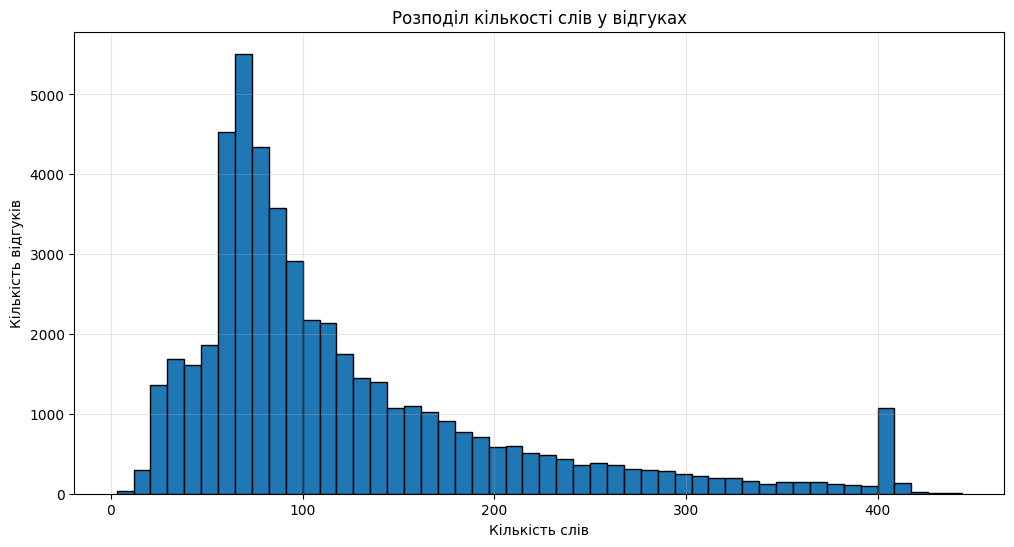

In [6]:
plt.figure(figsize=(12, 6))
plt.hist(word_counts, bins=50, edgecolor='black')
plt.title("Розподіл кількості слів у відгуках")
plt.xlabel("Кількість слів")
plt.ylabel("Кількість відгуків")
plt.grid(alpha=0.3)
plt.show()

In [7]:
reviews = data['review_final'].tolist()
#y = data['label'].values

# Токенізація + Векторизація нейронкою

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
X_embeddings = model.encode(reviews, batch_size=124, show_progress_bar=True, convert_to_numpy=True, device=device)

Batches:   0%|          | 0/404 [00:00<?, ?it/s]

# Створення експерименту для логування та збереження результатів векторизації

In [4]:
mlflow.set_experiment("review_trim_and_embeddings")

2025/12/09 14:04:21 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/09 14:04:21 INFO mlflow.store.db.utils: Updating database tables
2025/12/09 14:04:21 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/09 14:04:21 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/09 14:04:21 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/09 14:04:21 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/09 14:04:21 INFO mlflow.tracking.fluent: Experiment with name 'review_trim_and_embeddings' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:C:/Users/da4nik/sentiment-binary-classifier/mlruns/2', creation_time=1765281861854, experiment_id='2', last_update_time=1765281861854, lifecycle_stage='active', name='review_trim_and_embeddings', tags={}>

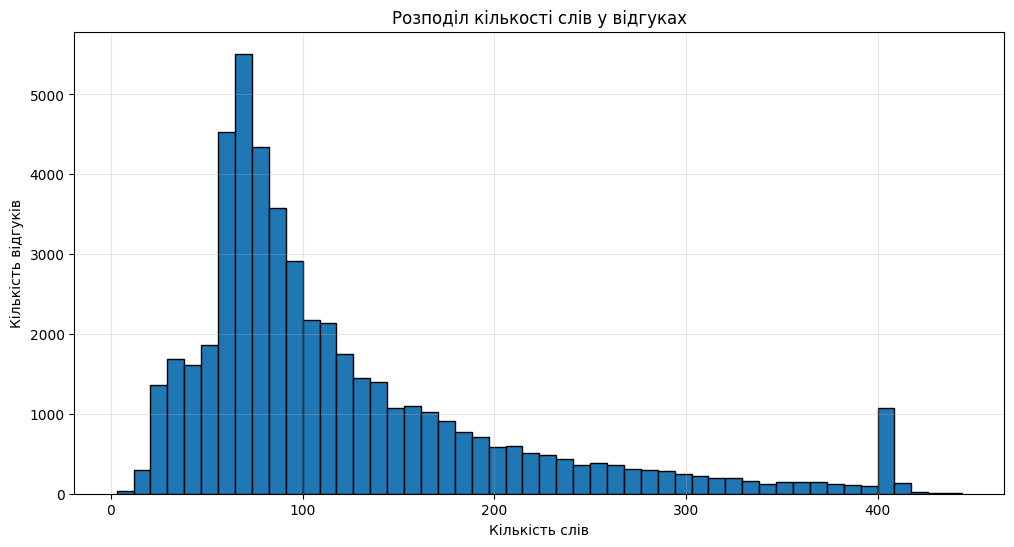

Batches:   0%|          | 0/404 [00:00<?, ?it/s]

In [5]:
with mlflow.start_run(run_name="trim_and_embed_all-MiniLM-L6-v2"):
    # trim settings
    mlflow.log_param("max_words", 400)
    mlflow.log_param("extra_cutoff", 50)
    mlflow.log_param("embedding_model", "sentence-transformers/all-MiniLM-L6-v2")

    data['review_final'] = data['review_final'].apply(trim_review)

    word_counts = data["review_final"].str.split().str.len()
    mlflow.log_metric("avg_words", float(word_counts.mean()))
    mlflow.log_metric("min_words", int(word_counts.min()))
    mlflow.log_metric("max_words", int(word_counts.max()))

    plt.figure(figsize=(12, 6))
    plt.hist(word_counts, bins=50, edgecolor='black')
    plt.title("Розподіл кількості слів у відгуках")
    plt.xlabel("Кількість слів")
    plt.ylabel("Кількість відгуків")
    plt.grid(alpha=0.3)

    # save histogram
    hist_path = "assets/word_count_hist.png"
    plt.savefig(hist_path, bbox_inches="tight")
    mlflow.log_artifact(hist_path, artifact_path="plots")
    plt.show()
    plt.close()

    reviews = data['review_final'].tolist()
    y = data['label'].values

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    mlflow.log_param("device", device)

    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)
    X_embeddings = model.encode(
        reviews,
        batch_size=124,
        show_progress_bar=True,
        convert_to_numpy=True
    )

    np.save("dataset/X_embeddings.npy", X_embeddings)
    np.save("dataset/y_labels.npy", y)

    mlflow.log_artifact("dataset/X_embeddings.npy", artifact_path="data")
    mlflow.log_artifact("dataset/y_labels.npy", artifact_path="data")

# Візуалізація векторизованих відгуків

In [11]:
colors = ['red', 'blue']   # negative=red, positive=blue
point_colors = [colors[label] for label in y]

In [12]:
umap_2d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)
umap_3d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=3,
    metric='cosine',
    random_state=42
)

In [13]:
X_umap_2d = umap_2d.fit_transform(X_embeddings)
X_umap_3d = umap_3d.fit_transform(X_embeddings)

C:\Program Files\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Program Files\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Program Files\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Program Files\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


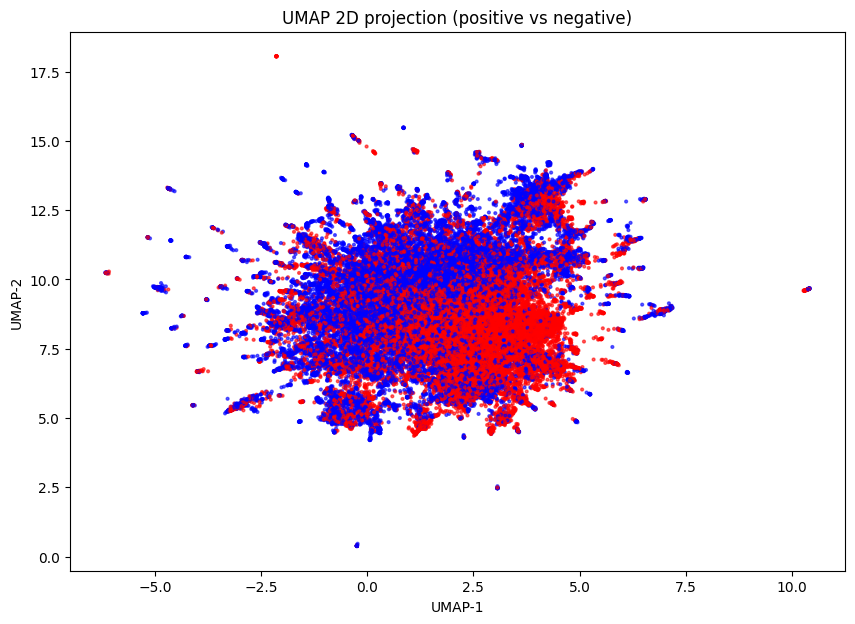

In [14]:
plt.figure(figsize=(10, 7))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], s=4, alpha=0.6, c=point_colors)
plt.title("UMAP 2D projection (positive vs negative)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

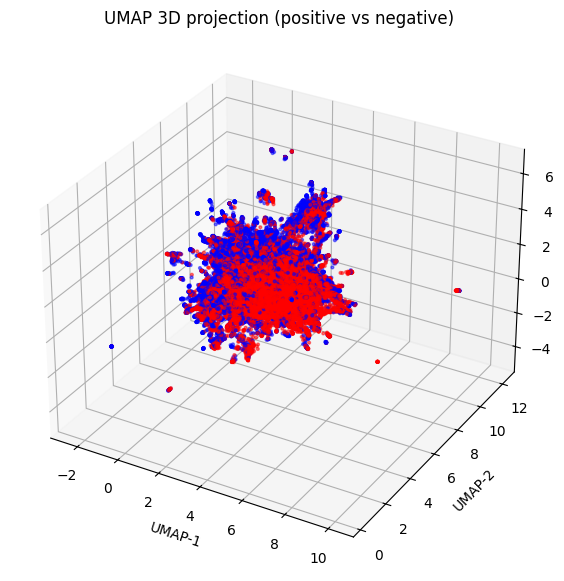

In [15]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_umap_3d[:, 0],
    X_umap_3d[:, 1],
    X_umap_3d[:, 2],
    s=4,
    alpha=0.5,
    c=point_colors
)

ax.set_title("UMAP 3D projection (positive vs negative)")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")

plt.show()

# ML Models

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.base import clone
from sklearn.utils import shuffle
import mlflow.sklearn
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [10]:
X_embeddings = np.load("dataset/X_embeddings.npy")
y = np.load("dataset/y_labels.npy")

# 5 рандомних відгуків

In [11]:
n = len(y)
indices = np.arange(n)

rng = np.random.default_rng(42)
rng.shuffle(indices)

holdout_idx = indices[:5]
train_idx = indices[5:]

In [12]:
X_train = X_embeddings[train_idx]
y_train = y[train_idx]
reviews_train = [reviews[i] for i in train_idx]

X_holdout = X_embeddings[holdout_idx]
y_holdout = y[holdout_idx]
reviews_holdout = [reviews[i] for i in holdout_idx]

# Models

In [13]:
def cross_validate_metrics(X, y, model, n_splits: int = 5, random_state: int = 42):
    kf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    metric_history = {"accuracy":  [],
                      "precision": [],
                      "recall":    [],
                      "f1_score":  [],
                      "roc_auc":   []}

    fold_scores = []  # для логу по фолдам
    fold_idx = 0
    for train_idx, val_idx in tqdm(kf.split(X, y), total=kf.get_n_splits()):
        fold_idx += 1

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = clone(model)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_val)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_score = clf.decision_function(X_val)
        else:
            y_score = y_pred

        fold_metrics = {
            "accuracy":  accuracy_score(y_val, y_pred),
            "precision": precision_score(y_val, y_pred, average='binary'),
            "recall":    recall_score(y_val, y_pred, average='binary'),
            "f1_score":  f1_score(y_val, y_pred, average='binary'),
            "roc_auc":   roc_auc_score(y_val, y_score)
        }

        for name, value in fold_metrics.items():
            metric_history[name].append(value)

        fold_scores.append((y_val, y_pred, y_score))

    return metric_history, fold_scores

In [14]:
def print_cross_valid_summary(metric_history, mean_metrics, std_metrics):
    print("\n===== CROSS-VALIDATION SUMMARY =====\n")

    print("Mean metrics:")
    for k, v in mean_metrics.items():
        print(f"  {k:10s} = {v:.5f}")
    
    print("\nStd metrics:")
    for k, v in std_metrics.items():
        print(f"  {k:10s} = {v:.5f}")
    
    # Додаткові метрики стабільності
    print("\nAdditional CV evaluation:")
    print(f"  Accuracy range : {min(metric_history['accuracy']):.5f} → {max(metric_history['accuracy']):.5f}")
    print(f"  F1-score range : {min(metric_history['f1_score']):.5f} → {max(metric_history['f1_score']):.5f}")
    print(f"  ROC-AUC range  : {min(metric_history['roc_auc']):.5f} → {max(metric_history['roc_auc']):.5f}")
    
    # коефіцієнт варіації (чим нижчий — тим стабільніша модель)
    print("\nCoefficient of variation (%):")
    for k in mean_metrics.keys():
        cv = (std_metrics[k] / mean_metrics[k]) * 100 if mean_metrics[k] != 0 else 0
        print(f"  {k:10s} = {cv:.2f}%")
    
    print("\n====================================\n")

In [16]:
def evaluate_model_cv(X, y, model, experiment_name: str, run_name: str | None = None, n_splits: int = 5,
                      random_state: int = 42):
    
    if run_name is None:
        run_name = f"{model.__class__.__name__}_{n_splits}fold_cv"

    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=run_name):

        mlflow.log_param("model_class", model.__class__.__name__)
        if hasattr(model, "get_params"):
            for p_name, p_val in model.get_params().items():
                mlflow.log_param(p_name, p_val)

        metric_history, fold_scores = cross_validate_metrics(
            X=X,
            y=y,
            model=model,
            n_splits=n_splits,
            random_state=random_state
        )

        # лог метрик по фолдах у MLflow
        for fold_idx, (y_val, y_pred, y_score) in enumerate(fold_scores, start=1):
            mlflow.log_metric(f"accuracy_fold{fold_idx}", accuracy_score(y_val, y_pred), step=fold_idx)
            mlflow.log_metric(f"precision_fold{fold_idx}", precision_score(y_val, y_pred, average='binary'), step=fold_idx)
            mlflow.log_metric(f"recall_fold{fold_idx}", recall_score(y_val, y_pred, average='binary'), step=fold_idx)
            mlflow.log_metric(f"f1_score_fold{fold_idx}", f1_score(y_val, y_pred, average='binary'), step=fold_idx)
            mlflow.log_metric(f"roc_auc_fold{fold_idx}", roc_auc_score(y_val, y_score), step=fold_idx)

        # середні та std
        mean_metrics = {name: float(np.mean(vals)) for name, vals in metric_history.items()}
        std_metrics  = {name: float(np.std(vals))  for name, vals in metric_history.items()}

        for name, value in mean_metrics.items():
            mlflow.log_metric(f"{name}_mean", value)
        for name, value in std_metrics.items():
            mlflow.log_metric(f"{name}_std", value)

        # модель на всіх (-5) даних
        final_model = clone(model)
        final_model.fit(X, y)
        mlflow.sklearn.log_model(final_model, name="final_model")

        # графік середніх метрик
        metric_names = list(mean_metrics.keys())
        metric_values = [mean_metrics[m] for m in metric_names]

        plt.figure(figsize=(8, 5))
        plt.bar(metric_names, metric_values)
        plt.ylim(0, 1.0)
        plt.title(f"{model.__class__.__name__} ({n_splits}-fold CV) metrics")
        plt.ylabel("Score")
        plt.grid(axis='y', linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

        mlflow.log_figure(plt.gcf(), f"{model.__class__.__name__}_cv_metrics_barplot.png")
        plt.close()

    print_cross_valid_summary(metric_history, mean_metrics, std_metrics)
    return final_model

# Logistic Regression

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]
2025/12/09 19:34:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


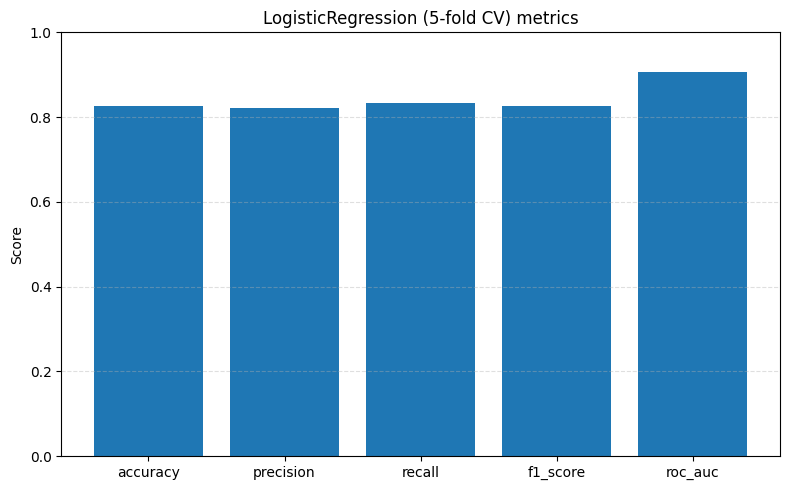


===== CROSS-VALIDATION SUMMARY =====

Mean metrics:
  accuracy   = 0.82566
  precision  = 0.82155
  recall     = 0.83214
  f1_score   = 0.82679
  roc_auc    = 0.90748

Std metrics:
  accuracy   = 0.00474
  precision  = 0.00678
  recall     = 0.00555
  f1_score   = 0.00442
  roc_auc    = 0.00400

Additional CV evaluation:
  Accuracy range : 0.81928 → 0.83268
  F1-score range : 0.82032 → 0.83368
  ROC-AUC range  : 0.90221 → 0.91323

Coefficient of variation (%):
  accuracy   = 0.57%
  precision  = 0.83%
  recall     = 0.67%
  f1_score   = 0.53%
  roc_auc    = 0.44%




In [55]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')

final_model = evaluate_model_cv(
    X=X_train,
    y=y_train,
    model=log_reg,
    experiment_name="imdb_ML_models",
    run_name="log_reg_sentence_embeddings_5fold_v3"
)

# SVM (LinearSVC)

2025/12/09 20:16:13 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/09 20:16:13 INFO mlflow.store.db.utils: Updating database tables
2025/12/09 20:16:13 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/09 20:16:13 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/09 20:16:13 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/09 20:16:13 INFO alembic.runtime.migration: Will assume non-transactional DDL.
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.16s/it]


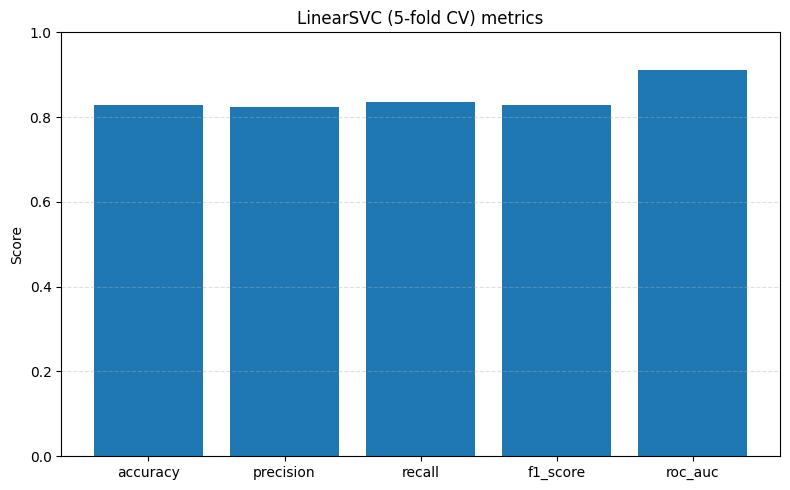


===== CROSS-VALIDATION SUMMARY =====

Mean metrics:
  accuracy   = 0.82816
  precision  = 0.82276
  recall     = 0.83658
  f1_score   = 0.82959
  roc_auc    = 0.91038

Std metrics:
  accuracy   = 0.00296
  precision  = 0.00436
  recall     = 0.00560
  f1_score   = 0.00300
  roc_auc    = 0.00333

Additional CV evaluation:
  Accuracy range : 0.82458 → 0.83318
  F1-score range : 0.82537 → 0.83472
  ROC-AUC range  : 0.90565 → 0.91504

Coefficient of variation (%):
  accuracy   = 0.36%
  precision  = 0.53%
  recall     = 0.67%
  f1_score   = 0.36%
  roc_auc    = 0.37%




In [17]:
svm_model = LinearSVC()
final_model_svm = evaluate_model_cv(
    X=X_train,
    y=y_train,
    model=svm_model,
    experiment_name="imdb_ML_models",
    run_name="svm_linear_sentence_embeddings_5fold_v3"
)

# Random Forest

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:04<00:00, 36.82s/it]


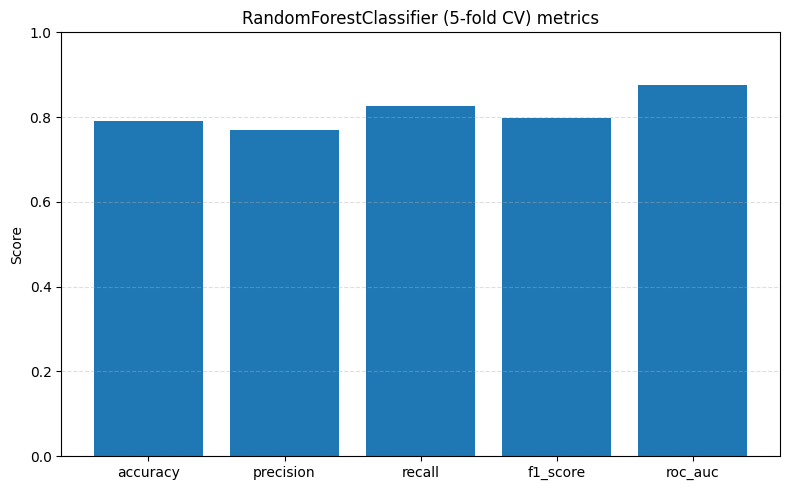


===== CROSS-VALIDATION SUMMARY =====

Mean metrics:
  accuracy   = 0.79022
  precision  = 0.77060
  recall     = 0.82650
  f1_score   = 0.79756
  roc_auc    = 0.87651

Std metrics:
  accuracy   = 0.00339
  precision  = 0.00427
  recall     = 0.00401
  f1_score   = 0.00308
  roc_auc    = 0.00390

Additional CV evaluation:
  Accuracy range : 0.78538 → 0.79418
  F1-score range : 0.79286 → 0.80081
  ROC-AUC range  : 0.87079 → 0.88110

Coefficient of variation (%):
  accuracy   = 0.43%
  precision  = 0.55%
  recall     = 0.49%
  f1_score   = 0.39%
  roc_auc    = 0.45%




In [18]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

final_model_rf = evaluate_model_cv(
    X=X_train,
    y=y_train,
    model=rf_model,
    experiment_name="imdb_ML_models",
    run_name="random_forest_sentence_embeddings_5fold_v1"
)

# XGBoost Classifier

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:32<00:00, 54.49s/it]


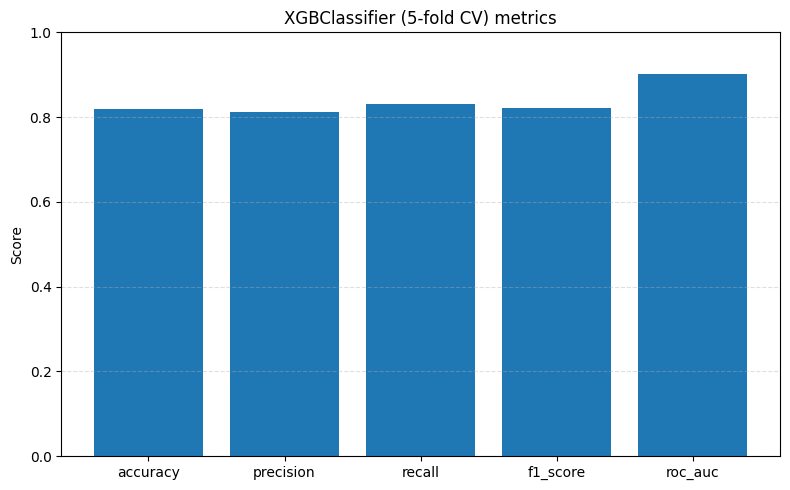


===== CROSS-VALIDATION SUMMARY =====

Mean metrics:
  accuracy   = 0.81952
  precision  = 0.81215
  recall     = 0.83142
  f1_score   = 0.82166
  roc_auc    = 0.90215

Std metrics:
  accuracy   = 0.00509
  precision  = 0.00746
  recall     = 0.00151
  f1_score   = 0.00435
  roc_auc    = 0.00434

Additional CV evaluation:
  Accuracy range : 0.81388 → 0.82818
  F1-score range : 0.81688 → 0.82902
  ROC-AUC range  : 0.89582 → 0.90702

Coefficient of variation (%):
  accuracy   = 0.62%
  precision  = 0.92%
  recall     = 0.18%
  f1_score   = 0.53%
  roc_auc    = 0.48%




In [19]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    n_jobs=-1
)

final_model_xgb = evaluate_model_cv(
    X=X_train,
    y=y_train,
    model=xgb_model,
    experiment_name="imdb_ML_models",
    run_name="xgboost_sentence_embeddings_5fold_v1"
)

# NN Model

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Fine-tune

In [ ]:
class MiniLMSentimentClassifier(nn.Module):
    def __init__(self, dropout_p: float = 0.5, device: str = "cuda"):
        super().__init__()

        self.encoder = SentenceTransformer(
            "sentence-transformers/all-MiniLM-L6-v2",
            device=device
        )
        self.encoder.max_seq_length = 512
        embedding_dim = self.encoder.get_sentence_embedding_dimension()

        self.fc1 = nn.Linear(embedding_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.out = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_p)

        self.init_weights()

    def init_weights(self):
        for layer in [self.fc1, self.fc2, self.out]:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0.0)

    def forward(self, texts: list[str]) -> torch.Tensor:
        embeddings = self.encoder.encode(   # він сам токенізує, робить падинг + маску і обрізає до 512 токенів  
            texts,
            convert_to_tensor=True,
            show_progress_bar=False
        )  # output shape: (batch, embedding_dim)

        x = self.dropout(F.relu(self.bn1(self.fc1(embeddings))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        logits = self.out(x)  # (batch, 1)
        return logits

# New NN

In [23]:
class SentimentFCNet(nn.Module):
    def __init__(self, input_dim=384, dropout_p=0.2):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)

        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)

        self.out = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout_p)

        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        x = self.dropout(F.relu(self.bn4(self.fc4(x))))
        x = self.dropout(F.relu(self.bn5(self.fc5(x))))

        logits = self.out(x)
        return logits